# 等离子体电子声波：Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

## 模型
### 1D等离子体：双kappa运动电子+静止均匀分布离子
- 初始分布函数
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{v^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{v^2}{2T} \right)^{-\kappa_f} $$
                          
- 色散关系
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
其中$\xi_\sigma = \frac{\omega}{k \theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
上述色散关系将允许两支波，一支类似于fast electrons的Langmuir波（LW）；另一支类似于slow electrons的Acoustic波（KW，由两组分不同$\kappa$导致）

- 让KW展现出来的关键在于
    - 排除热电子LW，$\gamma_{KW} < \gamma_{LW}^{hot}$
    - KW本身不能过阻尼，$\gamma_{KW} \le \omega_r/(2\pi)$，满足此条件可获得存在较长时间的KW

## 数值理论分析

In [88]:
def fk(v):
    r_s = ( 1 + v**2/(kappa_s-3/2)/(2*T) )**(-kappa_s)
    r_f = ( 1 + v**2/(kappa_f-3/2)/(2*T) )**(-kappa_f)
    A_s = n_s/np.sqrt(2*np.pi*T*(kappa_s-3/2)) * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
    A_f = n_f/np.sqrt(2*np.pi*T*(kappa_f-3/2)) * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
    
    return A_s*r_s+A_f*r_f

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + (kappa_f/(kappa_f-1.5)) / k**2 / l_f**2 * ( 1 - 1/2/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f) )
    return [r.real,r.imag]

def PDR_1KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) )
    return [r.real,r.imag]

import quadpy

def dispersion_function(zeta,kappa):
    r = 0.0
    A_kappa = (kappa)**(-1.5) * sp.gamma(kappa+1) / sp.gamma(kappa-0.5)
    def integrand(xi):
        return  (1+xi**2/kappa)**(-kappa-1)
    if zeta.imag>0:
        r = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,np.inf)[0]
    elif zeta.imag==0:
        x = 0.1
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1 = (1/np.sqrt(np.pi)) * integrate.quad(integrand,s_n,s_p, weight='cauchy',wvar=zeta.real)[0]
        real2 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = (1/np.sqrt(np.pi)) * quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = real + 1j*imag
    elif zeta.imag<0:
        x = 1e-8
        s_p = zeta.real + x
        s_n = zeta.real - x
        real1a = -1j * quadpy.quad(lambda xi_i: integrand(s_n+1j*xi_i)/(1j*xi_i-1j*zeta.imag-x),zeta.imag,0)[0]
        real1b =  1j * quadpy.quad(lambda xi_i: integrand(s_p+1j*xi_i)/(1j*xi_i-1j*zeta.imag+x),zeta.imag,0)[0]
        real2 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),-np.inf,s_n)[0]
        real3 = quadpy.quad(lambda xi: integrand(xi)/(xi-zeta),s_p,np.inf)[0]
        real = real1a+real1b+real2+real3
        imag = np.sqrt(np.pi) * integrand(zeta)
        r = (1/np.sqrt(np.pi)) * real + 1j*imag
    return r * A_kappa

def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,kappa_f,round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt((2-3/kappa_f)*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### PDR中的KW分支和LW分支

In [90]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

n_s = 0.5
kappa_s = 1.51
kappa_f = 100

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+-----+-----+-------+--------+--------+----------+
| T=1 |  n  | kappa |   wp   | theta  | lambda_D |
+-----+-----+-------+--------+--------+----------+
|  s  | 0.5 |  1.51 | 0.7071 | 0.1151 |  1.4142  |
|  f  | 0.5 |  100  | 0.7071 | 1.4036 |  1.4142  |
+-----+-----+-------+--------+--------+----------+


In [63]:
k_list = np.linspace(0.1,1.5,num=45)
# 搜索解方程初值
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.036,-0.022])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.0,-1.0e-4])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.07392335 -0.04397842]
True [ 1.00842956e+00 -5.30300866e-05]


In [64]:
wr_kw_guess = 0.036
wi_kw_guess = -0.022
wr_lw_guess = 1.0
wi_lw_guess = -1.0e-4

wr_lw_list = []
wi_lw_list = []
wr_kw_list = []
wi_kw_list = []

for k_each in tqdm(k_list,position=0,leave=True):
    s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
    if s_kw.success==True:
        wr_kw = s_kw.x[0]
        wi_kw = s_kw.x[1]
        wr_kw_guess = wr_kw
        wi_kw_guess = wi_kw
        wr_kw_list.append(wr_kw)
        wi_kw_list.append(wi_kw)

    s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
    if s_lw.success==True:
        wr_lw = s_lw.x[0]
        wi_lw = s_lw.x[1]
        wr_lw_guess = wr_lw
        wi_lw_guess = wi_lw
        wr_lw_list.append(wr_lw)
        wi_lw_list.append(wi_lw)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [02:53<00:00,  3.85s/it]


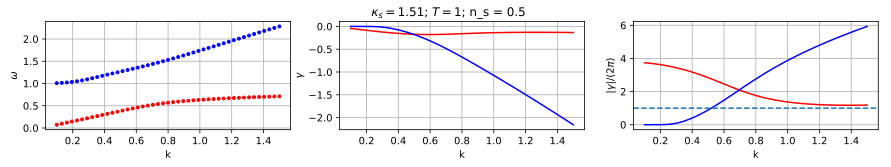

In [65]:
fig = plt.figure(figsize=(15,2))

ax1 = plt.subplot(131)
ax1.plot(k_list,wr_kw_list,'.',color='red')
ax1.plot(k_list,wr_lw_list,'.',color='blue')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$\omega$')
ax1.grid()

ax2 = plt.subplot(132)
ax2.plot(k_list,wi_kw_list,color='red')
ax2.plot(k_list,wi_lw_list,color='blue')
ax2.set_xlabel('k')
ax2.set_ylabel(r'$\gamma$')
ax2.grid()

b_kw = abs(np.array(wi_kw_list)/(np.array(wr_kw_list)/2/np.pi))
b_lw = abs(np.array(wi_lw_list)/(np.array(wr_lw_list)/2/np.pi))
ax3 = plt.subplot(133)
ax3.plot(k_list,b_kw,color='red')
ax3.plot(k_list,b_lw,color='blue')
ax3.axhline(1,linestyle='--')
ax3.set_xlabel('k')
ax3.set_ylabel(r'$|\gamma|/(2\pi)$')
ax3.grid()
plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $T = $"+str(T)+"; n_s = "+str(n_s))
plt.show()

### KW波色散关系随T变化规律

In [66]:
k_list = np.linspace(0.1,1.5,num=15)
T_list = np.linspace(1,100,num=10)

In [68]:
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[0.073,-0.043])
s1=op.root(lambda w:PDR_2KE(w,k_list[0]),[1.008,-5.3e-5])
print('k = ',k_list[0])
print(s0.success,s0.x)
print(s1.success,s1.x)

k =  0.1
True [ 0.07392335 -0.04397842]
True [ 1.00842956e+00 -5.30300878e-05]


In [72]:
wr_lw_mat = []
wi_lw_mat = []
wr_kw_mat = []
wi_kw_mat = []
b_mat = []

for T_each in tqdm(T_list,position=0,leave=True):
    T = T_each
    n_s = 0.5
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )

    v_s = np.sqrt((2-3/kappa_s)*T/m)
    v_f = np.sqrt((2-3/kappa_f)*T/m)

    wr_lw_list = []
    wi_lw_list = []
    wr_kw_list = []
    wi_kw_list = []
    
    wr_kw_guess = 0.073
    wi_kw_guess = -0.043
    wr_lw_guess = 1.008
    wi_lw_guess = -5.3e-5
    
    for k_each in k_list:
        s_kw = op.root(lambda w:PDR_2KE(w,k_each),[wr_kw_guess,wi_kw_guess])
        if s_kw.success==True:
            wr_kw = round(s_kw.x[0],6)
            wi_kw = round(s_kw.x[1],6)
            wr_kw_guess = wr_kw
            wi_kw_guess = wi_kw
            if wr_kw not in wr_kw_list:
                wr_kw_list.append(wr_kw)
                wi_kw_list.append(wi_kw)

        s_lw = op.root(lambda w:PDR_2KE(w,k_each),[wr_lw_guess,wi_lw_guess])
        if s_lw.success==True:
            wr_lw = round(s_lw.x[0],6)
            wi_lw = round(s_lw.x[1],6)
            wr_lw_guess = wr_lw
            wi_lw_guess = wi_lw
            if wr_lw not in wr_lw_list:
                wr_lw_list.append(wr_lw)
                wi_lw_list.append(wi_lw)
        b_list = abs(np.array(wi_kw_list)/(np.array(wr_kw_list)/2/np.pi))
    wr_kw_mat.append(wr_kw_list)
    wi_kw_mat.append(wi_kw_list)
    wr_lw_mat.append(wr_lw_list)
    wi_lw_mat.append(wi_lw_list)
    b_mat.append(b_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:38<00:00, 81.87s/it]


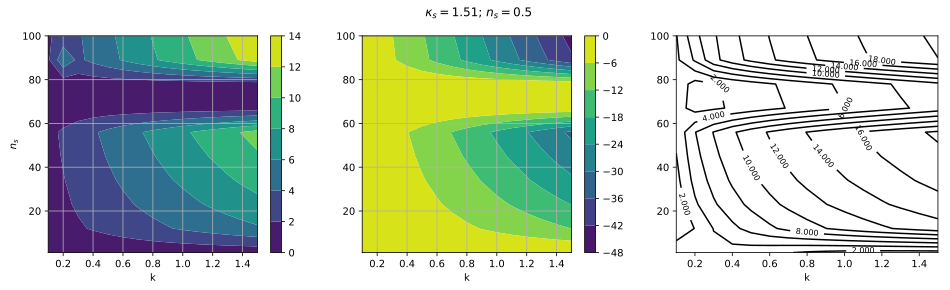

In [80]:
k_grid,T_grid=np.meshgrid(k_list,T_list)
fig = plt.figure(figsize=(16,4))

ax1 = plt.subplot(131)
cm1 = ax1.contourf(k_grid,T_grid,wr_kw_mat)
ax1.set_xlabel('k')
ax1.set_ylabel(r'$n_s$')
ax1.grid()
fig.colorbar(cm1)

ax2 = plt.subplot(132)
cm2 = ax2.contourf(k_grid,T_grid,wi_kw_mat)
ax2.set_xlabel('k')
ax2.grid()
fig.colorbar(cm2)

ax3 = plt.subplot(133)
# ax3.contourf(k_grid,T_grid,b_mat)
c = ax3.contour(k_grid,T_grid,b_mat,levels=10,colors='black')
ax3.clabel(c,inline=True,fontsize=8)
ax3.set_xlabel('k')
# ax3.grid()

plt.suptitle(r"$\kappa_s = $"+str(kappa_s)+"; $n_s = $"+str(n_s))
plt.show()

## 模拟验证

### 模拟参数设定

In [91]:
T = 5
n_s = 0.1
kappa_s = 1.501
kappa_f = 100
n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

k = 0.6
L = 2*np.pi/k

vmax = 15 # 速度最大值
nx = 401
nv = 1001
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
dt = 0.01
max_steps  = 10000
data_steps = 2000
data_num = int(max_steps/data_steps)+1
d = 0.001

path = '../data/'
print(data_num)
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)
print('2w2/k2v2=', 2*wp_f**2/(k*v_f)**2)

+-----+-----+-------+--------+--------+----------+
| T=5 |  n  | kappa |   wp   | theta  | lambda_D |
+-----+-----+-------+--------+--------+----------+
|  s  | 0.1 | 1.501 | 0.3162 | 0.0816 |  7.0711  |
|  f  | 0.9 |  100  | 0.9487 | 3.1385 |  2.357   |
+-----+-----+-------+--------+--------+----------+
6
limited time= 349.06585039886596
real time =  100.0
2w2/k2v2= 0.5076142131979696


In [97]:
s_lw_sim=op.root(lambda w:PDR_2KE(w,k),[1.23,-0.3])
s_kw_sim=op.root(lambda w:PDR_2KE(w,k),[0.23,-0.03])
print(s_lw_sim.success,s_lw_sim.x)
print(s_kw_sim.success,s_kw_sim.x)

True [ 2.37397045 -1.51127142]
True [ 0.27619221 -0.03433363]


### KW条件检验
- $\gamma_{KW} < \gamma_{LW}^{hot}$

In [98]:
print('r_kw = ',round(abs(s_kw_sim.x[1]),6))
print('r_lw = ',round(abs(s_lw_sim.x[1]),6))

r_kw =  0.034334
r_lw =  1.511271


- $k\lambda_h \le 1$

In [99]:
print('k*l_D_f = ',round(k*l_f,6))

k*l_D_f =  1.414214


- $\gamma_{KW} < \omega_r/(2\pi)$

In [101]:
print('r_eaw   = ',round(abs(s_kw_sim.x[1]),6))
print('wr/2/pi = ',round(s_kw_sim.x[0]/2/np.pi,6))

r_eaw   =  0.034334
wr/2/pi =  0.043957


### 模拟结果

In [102]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

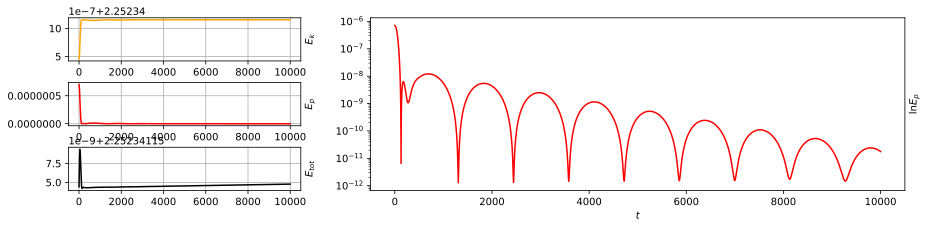

In [103]:
fig = plt.figure(figsize=(15, 3))

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.grid()
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 3), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.grid()
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.grid()
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 3), (0, 1),colspan=2, rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.3)
plt.xlabel(r'$t$')
plt.show()

In [104]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

In [105]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L

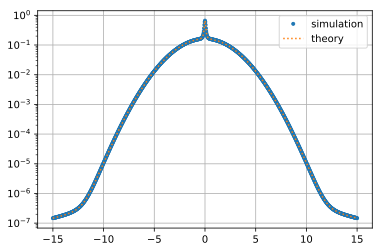

In [107]:
plt.plot(v,fv0,'.',label='simulation')
plt.plot(v,fk(v),':',label='theory')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

$$ E_p \propto E^2 \propto \left( e^{i \omega_r t+\omega_i t} \right)^2 = e^{i 2\omega_r t+2\omega_i t} $$

In [110]:
def PlotWaveFreq(t,y,refFreq,refFreq2):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(10,3))
    
    ax2 = plt.subplot()
    k_plot_scale=n//30
    ax2.plot(np.pi*x_k[1:k_plot_scale],2*y_k_abs[1:k_plot_scale]/n,color='black',lw=2)
    ax2.axvline(refFreq,color='red',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq,6)))
    ax2.axvline(refFreq2,color='orange',ls='--',label=r'$\omega_{KW}$ = '+str(round(refFreq2,6)))
    ax2.set_title('freq-wave')
    ax2.set_xlabel(r'$\omega$')
    ax2.set_ylabel('A')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs((a-b)/b)
    return r

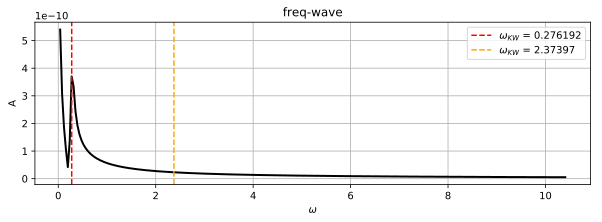

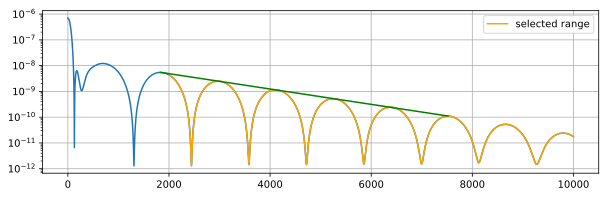

In [113]:
start = 2000
end = 10000

indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[2:8:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
wr_sim = 2*np.pi/per_sim/2
wi_sim = para[0]/dt/2

PlotWaveFreq(t[start:end],dataep[start:end],s_kw_sim.x[0],s_lw_sim.x[0])
fig = plt.figure(figsize=(10,3))
plt.plot(t,dataep)
plt.plot(t[start:end],dataep[start:end],color='orange',label='selected range')
plt.plot(xep,np.exp(line(para,xep)), '-',color='green')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [115]:
wr0_err = abs(wr_sim-s_kw_sim.x[0])/s_kw_sim.x[0]*100
wr1_err = abs(wr_sim-s_lw_sim.x[0])/s_lw_sim.x[0]*100
wi0_err = abs(abs(wi_sim)-abs(s_kw_sim.x[1]))/abs(s_kw_sim.x[1])*100
wi1_err = abs(abs(wi_sim)-abs(s_lw_sim.x[1]))/abs(s_lw_sim.x[1])*100
com_table = PrettyTable(['EAW: k='+str(k),'wr','wi'])
com_table.add_row(['Theory0',round(s_kw_sim.x[0],6),round(abs(s_kw_sim.x[1]),6)])
com_table.add_row(['Theory1',round(s_lw_sim.x[0],6),round(abs(s_lw_sim.x[1]),6)])
com_table.add_row(['Simulation',round(wr_sim,6),round(abs(wi_sim),6)])
com_table.add_row(['Error0(%)',round(wr0_err,6),round(abs(wi0_err),6)])
com_table.add_row(['Error1(%)',round(wr1_err,6),round(abs(wi1_err),6)])
print(com_table)

+------------+-----------+-----------+
| EAW: k=0.6 |     wr    |     wi    |
+------------+-----------+-----------+
|  Theory0   |  0.276192 |  0.034334 |
|  Theory1   |  2.37397  |  1.511271 |
| Simulation |  0.276305 |  0.034287 |
| Error0(%)  |  0.04099  |  0.134978 |
| Error1(%)  | 88.361042 | 97.731229 |
+------------+-----------+-----------+
